In [21]:
import requests
from bs4 import BeautifulSoup
import datetime
import time

def get_news_articles(query, start_date, end_date, max_articles=1000):
    articles = []
    current_date = start_date

    while current_date <= end_date and len(articles) < max_articles:
        for start in range(1, 100, 10):  # 한 페이지에 10개씩 가져옴
            url = f"https://search.naver.com/search.naver?where=news&query={query}&sort=0&ds={current_date.strftime('%Y.%m.%d')}&de={current_date.strftime('%Y.%m.%d')}&start={start}"

            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
            }

            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')

            news_items = soup.select('div.group_news > ul.list_news > li')  # HTML 구조에 맞게 선택자 수정

            for item in news_items:
                title_tag = item.select_one('a.news_tit')
                description_tag = item.select_one('div.news_dsc')
                date_tag = item.select_one('span.info')
                link = title_tag['href'] if title_tag else None
                title = title_tag.get_text(strip=True) if title_tag else None
                description = description_tag.get_text(strip=True) if description_tag else None
                date = None

                if date_tag:
                    date_text = date_tag.get_text(strip=True)
                    if '전' not in date_text and '시간' not in date_text and '일' not in date_text:
                        date = date_text
                    else:
                        date = current_date.strftime('%Y.%m.%d')

                if title and link and description:
                    articles.append({
                        'title': title,
                        'link': link,
                        'description': description,
                        'date': date
                    })

                if len(articles) >= max_articles:
                    break

            time.sleep(1)  # 너무 빠른 요청을 방지하기 위해 대기

        current_date += datetime.timedelta(days=1)

    return articles

start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime.now()
query = "연방준비제도 금리"

articles = get_news_articles(query, start_date, end_date)

print(f"총 {len(articles)}개의 기사가 수집되었습니다.")

#예시 표시
if articles:
    print(articles[0])


총 1000개의 기사가 수집되었습니다.
{'title': '美 연준,금리인하 시야에 들어오기 시작', 'link': 'http://www.fnnews.com/news/202407282146257089', 'description': '미국 중앙은행인연방준비제도(연준)의금리인하가 점차 다가오고 있다. 외신들은 이번주에 열리는 통화정책회의에서는금리가 변동이 없겠으나 9월 인하를 시사하는 중대한 회의가 될 것이라고 보도하고 있다. 올해초 올랐던 미국 소비자물가가 뚜렷하게 하락세를 보이고 있고 노동시장이 냉각되는 것을 볼...', 'date': '2014.01.01'}


In [22]:
import pandas as pd

df = pd.DataFrame(articles)

def parse_date(date_str):
    for fmt in ('%Y.%m.%d.', '%Y.%m.%d'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.to_datetime(date_str, errors='coerce')

df['date'] = df['date'].apply(parse_date)

df['title'] = df['title'].str.replace('<.*?>', '', regex=True)
df['description'] = df['description'].str.replace('<.*?>', '', regex=True)

print(f"총 {len(df)}개의 기사가 수집되었습니다.")
display(df.head())

df.to_csv('news_articles.csv', index=False)


총 1000개의 기사가 수집되었습니다.


,title,link,description,date
0,"美 연준,금리인하 시야에 들어오기 시작",http://www.fnnews.com/news/202407282146257089,미국 중앙은행인연방준비제도(연준)의금리인하가 점차 다가오고 있다. 외신들은 이번주에...,2014-01-01
1,국고채금리일제히 연저점…3년물 26개월 만에 2%대 진입,https://www.newsis.com/view/NISX20240729_00028...,미국의 6월 PCE(개인소비지출)이 시장 예상치에 부합하면서 시카고상품거래소(CME...,2014-01-01
2,"""9월금리인하 확신…인플레 리스크도 못 꺾어""",http://www.wowtv.co.kr/NewsCenter/News/Read?ar...,"29일(현지시간) CNBC에 따르면 시겔은 ""미국연방준비제도(Fed·연준)의 9월금...",2014-01-01
3,"[미장브리핑] FT ""美 연준금리인하 서두를 필요없어""",https://zdnet.co.kr/view/?no=20240730083111,(사진=이미지투데이) ▲파이낸셜타임즈는 투자자들이 9월 미국연방준비제도(연준)이금리...,2014-01-01
4,“28개월 만에 가장 낮은금리” 대출수요 또 몰릴까봐 안절부절[머니뭐니],https://news.heraldcorp.com/view.php?ud=202407...,시장에서 미연방준비제도(Fed)가 올 9월 ‘빅 컷(기준금리0.5%포인트 인하)’을...,2014-01-01


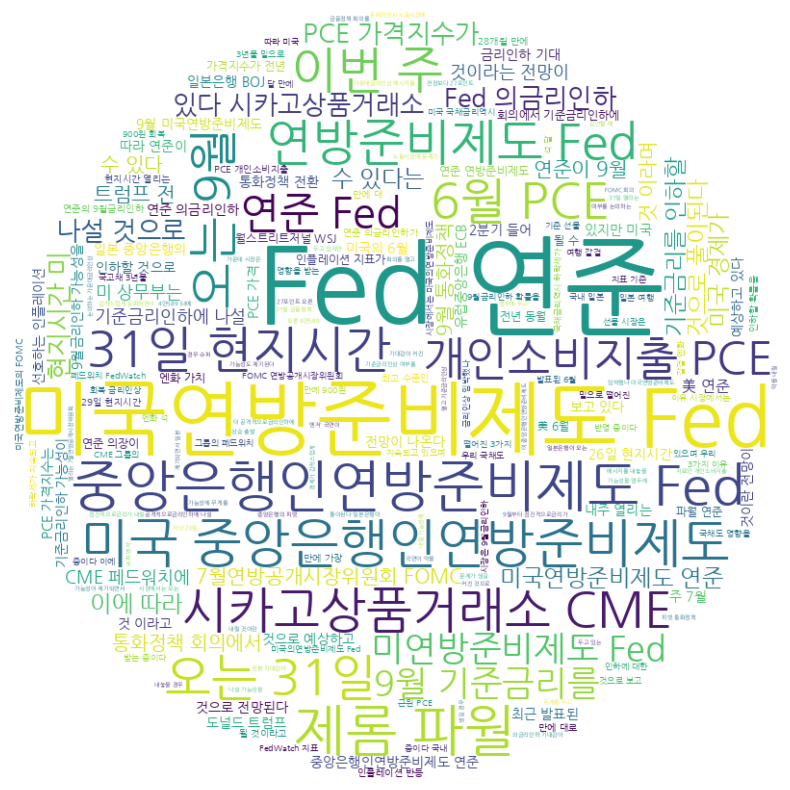

In [23]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

df = pd.read_csv('news_articles.csv')

text_data = df['title'] + " " + df['description']

text = " ".join(text_data)

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

#워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=800, background_color='white', mask=mask, colormap='viridis', 
                      stopwords={'및', '이', '그', '의', '를', '에', '가', '로'}).generate(text)

#시각화
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
